# Определение стоимости автомобилей

## Подготовка данных

### Загрузка данных

In [1]:
# импорт библиотек

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer

import lightgbm as lgb

In [2]:
# импорт данных

try:
    data = pd.read_csv('autos.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
    
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


После предварительного ознакомления с данными сделал следующие выводы:
- всего в таблице содержится 354 369 записей;
- в некоторых полях присутствуют пропуски;
- не все поля имеют релевантный формат;
- некоторые поля можно опустить в силу их неинформативности;
- присутствуют как количественные, так и категориальные признаки.

### Обработка данных

Для начала отсею ненужные и неинформативные поля. Такими будут:
- DateCrawled (техническое поле);
- RegistrationMonth (имеет малый смысл без привязки к году, самого года будет достаоочно);
- DateCreated (неинформативное поле);
- NumberOfPictures (поле везде имеет значение 0);
- PostalCode (неинформативное поле);
- LastSeen (неинформативное поле).

In [5]:
data2 = data.drop([
    'DateCrawled',
    'RegistrationMonth',
    'DateCreated',
    'NumberOfPictures',
    'PostalCode',
    'LastSeen'
    ], axis=1)

data2.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [6]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


После фильтрации полей осталось 9 признаков. Все форматы полей релевантны.

Для начала проверю категориальные признаки

In [7]:
data2['VehicleType'].value_counts(dropna=False)

sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

Присутсвуют 37490 записей, где тип кузова не указан. Скорее всего, это связано с тем, что данное поле не является обязательным к заполнению при создании объявления.

In [8]:
data2['Gearbox'].value_counts(dropna=False)

manual    268251
auto       66285
NaN        19833
Name: Gearbox, dtype: int64

In [9]:
data2['Model'].value_counts(dropna=False)

golf                  29232
other                 24421
3er                   19761
NaN                   19705
polo                  13066
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 251, dtype: int64

In [10]:
data2['FuelType'].value_counts(dropna=False)

petrol      216352
gasoline     98720
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [11]:
data2['Repaired'].value_counts(dropna=False)

no     247161
NaN     71154
yes     36054
Name: Repaired, dtype: int64

В вышеперечисленные поля также не являются обязательными к заполнению, поэтому в них присутсвуют пропуски. Однако, в поле FuelType одновременно присутсвуют gasoline (бензин на американском английском) и petrol (бензин на британском английском), что в сущности является одним и тем же. Таким образом, предлагаю заменить gasoline на petrol.

In [12]:
data2['FuelType'] = data2['FuelType'].replace('gasoline', 'petrol')

data2['FuelType'].value_counts(dropna=False)

petrol      315072
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [13]:
data2['Brand'].value_counts(dropna=False)

volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64

Поле с маркой автомобиля не имеет пропусков, следовательно, оно обязательно к заполнению.

В данном случае, пропуски в категориальных признаках тоже являются частью информации, которую следует учитывать в модели. Пропуск будет являеться одной из категорий для категориального признака.

Приступлю к количественным признакам

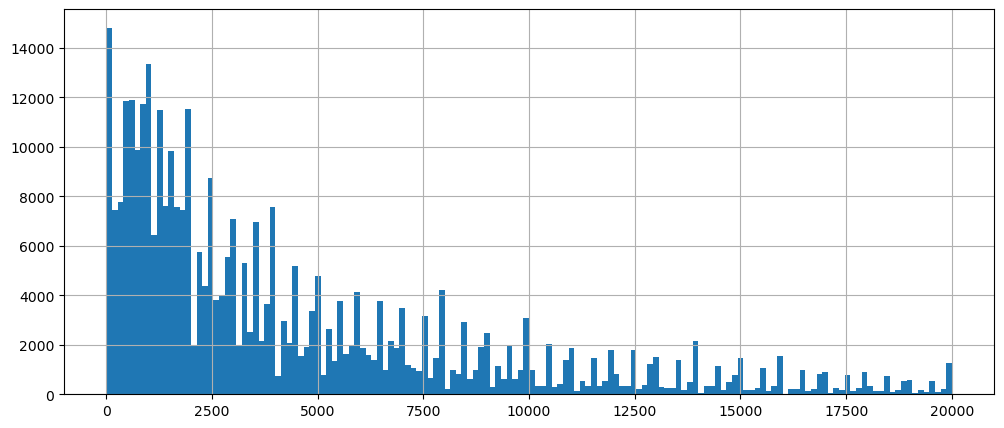

In [14]:
data2['Price'].hist(figsize=(12, 5), bins=150);

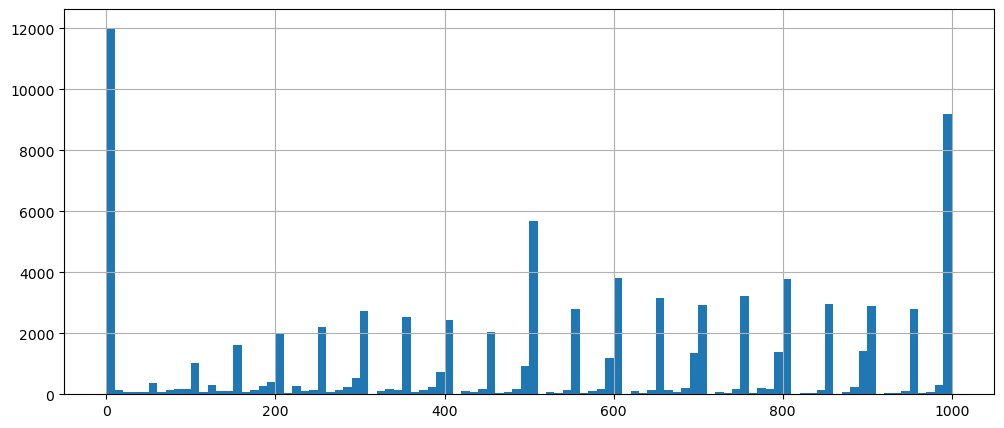

In [15]:
data2['Price'].hist(figsize=(12, 5), bins=100, range=(0, 1000));

Около 12 тыс. значений цены равно нулю. Это может быть связано с тем, что некоторые автомобиль готовы отдать бесплатно, однако, такие случаи являются, скорее, исключением. Удалю авто с такой ценой.

In [16]:
data3 = data2.copy()

data3 = data3.query('Price > 0')
data3.shape[0]

343597

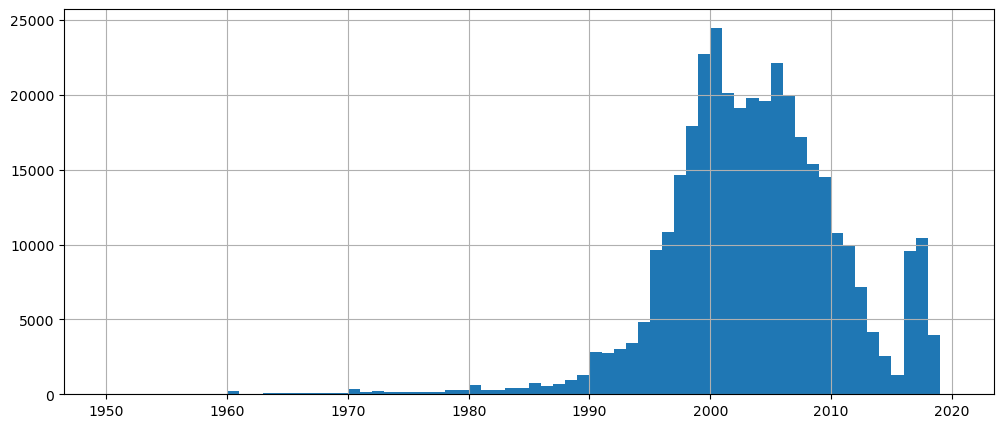

In [17]:
data2['RegistrationYear'].hist(figsize=(12, 5), bins=70, range=(1950, 2020));

Автомобилей, произведённых ранее 1970 года, крайне мало, их можно не рассматривать. Также автомобили, произведённые после 2016 года, существовать не могут, это ошибка.

In [18]:
data3 = data3.query('1970 <= RegistrationYear <= 2016')

data3.shape[0]

328643

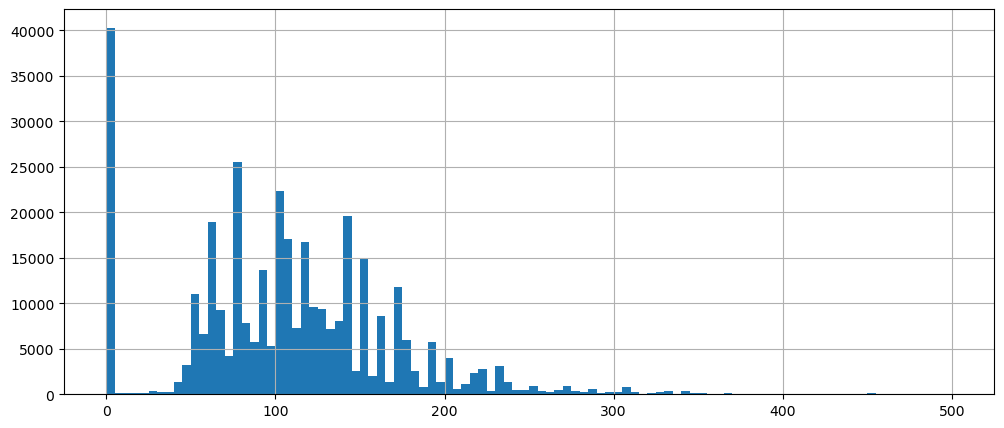

In [19]:
data2['Power'].hist(figsize=(12, 5), bins=100, range=(0, 500));

У более чем 40 тыс. объявлений автомобили имеют мощность 0 л.с. Это может быть связано с тем, что автомобили не имеют двигателя (например, после аварии). Таких объявлений слишком много, чтобы ими пренебрегать. Ограничу только верхнюю границу для мощности автомобиля.

In [20]:
data3 = data3.query('Power <= 400')

data3.shape[0]

327992

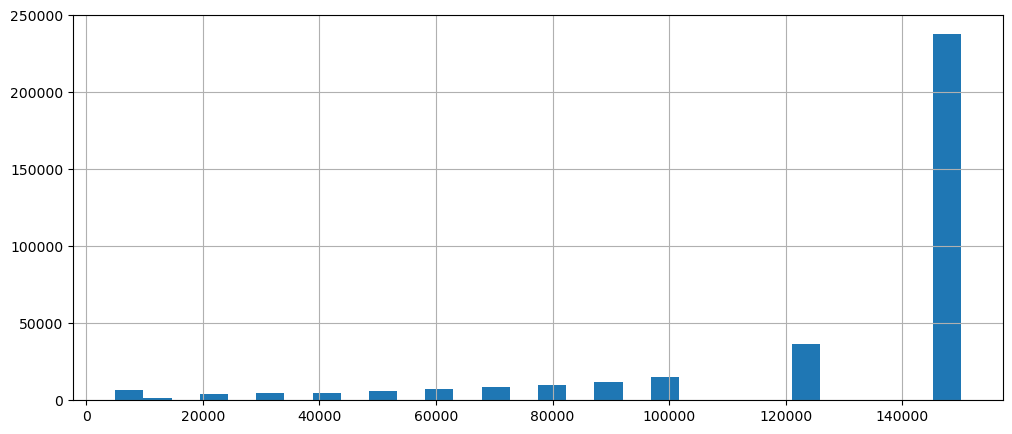

In [21]:
data2['Kilometer'].hist(figsize=(12,5), bins=30);

Для пробега явные выбросы не замечены.

При фильтрации количественных признаков было удалено 9.3% записей, что приемлимо. Также следует отметить, что все поля с количественными признаками, скорее всего, являются обязательными к заполнению, поэтому, они не содержат пропуски.

Проверю дубликаты в оставшихся данных. Однако, могут быть примерно одинаковые объявления, например, разные люди могут продавать одну и ту же модель по одной цене. Поэтому добавлю дату создания объявления и почтовый индекс пользователся, чтобы избежать удалениях похожих объявлений от разных людей.

In [22]:
data3 = data3.join(data[['DateCreated', 'PostalCode']]).drop_duplicates()

data3 = data3.drop(['DateCreated', 'PostalCode'], axis=1)

data3.shape[0]

317724

Подсчитаю потерю при фильтрации объявлений

In [23]:
(data3.shape[0] / data.shape[0] - 1) * 100

-10.340915825029839

При фильтрации количественных признаков было удалено 10.3% записей, что приемлимо. Также следует отметить, что все поля с количественными признаками, скорее всего, являются обязательными к заполнению, поэтому, они не содержат пропуски.

In [24]:
data3.duplicated().sum()

32781

### Краткий анализ

In [25]:
data3.describe()

,Price,RegistrationYear,Power,Kilometer
count,317724.000000,317724.000000,317724.000000,317724.000000
mean,4568.177629,2002.723354,108.134903,128426.464479
std,4522.417884,6.420191,61.475655,37337.885709
min,1.000000,1970.000000,0.000000,5000.000000
25%,1200.000000,1999.000000,71.000000,125000.000000
50%,2900.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2007.000000,143.000000,150000.000000
max,20000.000000,2016.000000,400.000000,150000.000000


In [26]:
data3.corr(method='spearman')

/var/folders/x8/094w_9t16wd6cl_75x01cqpw0000gn/T/ipykernel_20371/545918204.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data3.corr(method='spearman')


,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.638070,0.527692,-0.336035
RegistrationYear,0.638070,1.000000,0.197779,-0.348405
Power,0.527692,0.197779,1.000000,0.084241
Kilometer,-0.336035,-0.348405,0.084241,1.000000


**Выводы:**
- Средняя цена равна 4568 евро, разброс цен очень большой;
- Больше всего объявлений приходится на 2003 год;
- В среднем машины имеют мощность 108 л.с. и пробеш 128.5 тыс км;
- Для мощности и года выпуска наблюдается средневыраженная положительная корреляция с ценой;
- Для пробега наблюдается отрицательная корреляция немного ниже средневыраженной;
- Большая часть автомоблией ездит на бензине, имеет ручную коробку передач и являются седанами;
- Самая популярная марка авто - Volkswagen.

## Обучение моделей

### Подготовка выборок для обучения

Для начала заменю тип данных в столбцах с категориальными переменными на category в связи со спецификой работы некоторых библиотек машинного обучения

In [27]:
categorial_features = [
    'VehicleType',
    'Gearbox',
    'Model',
    'FuelType',
    'Brand',
    'Repaired'
]

for col in categorial_features:
    data3[col] = data3[col].astype('category')
    
data3.dtypes

Price                  int64
VehicleType         category
RegistrationYear       int64
Gearbox             category
Power                  int64
Model               category
Kilometer              int64
FuelType            category
Brand               category
Repaired            category
dtype: object

In [28]:
# разделю данные на признаки и таргет

features = data3.drop(['Price'], axis=1)
target = data3['Price']

features.shape, target.shape

((317724, 9), (317724,))

In [29]:
# отделю тестовую выборку

features_main, features_test, target_main, target_test = train_test_split(
    features, target, test_size=.2, random_state=0)

print(features_main.shape[0], features_test.shape[0])
print(target_main.shape[0], target_test.shape[0])

254179 63545
254179 63545


In [30]:
# сформирую тренировочную и валидациюнную выборки

features_train, features_valid, target_train, target_valid = train_test_split(
    features_main, target_main, test_size=.25, random_state=0)

print(features_train.shape[0], features_valid.shape[0])
print(target_train.shape[0], target_valid.shape[0])

190634 63545
190634 63545


### Градиентный бустинг

Начну с модели градиентного бустинга с помощью библиотеки LightGBM. Данная библиотека умеет работать с пропусками и категориальными признаками, поэтому не буду преобразовывать данные самостоятельно.

In [31]:
# задам параметры модели

params = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'num_leaves': 10,
    'learning_rate': 0.1,
    'metric': 'rmse', # т.к. проверятся метрика RMSE, то будем минимизировать именно эту метрику
    'verbosity': -1
}

# загрузка данных в модель

lgb_train = lgb.Dataset(features_train, target_train)
lgb_eval = lgb.Dataset(features_valid, target_valid, reference=lgb_train)

In [32]:
%%time

# обучение модели

model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 verbose_eval=False)

/Users/artemtarasov/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/artemtarasov/anaconda3/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/artemtarasov/anaconda3/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


CPU times: user 1.69 s, sys: 239 ms, total: 1.93 s
Wall time: 286 ms


In [33]:
%%time

predicted_valid = model.predict(features_valid)

CPU times: user 369 ms, sys: 10.7 ms, total: 379 ms
Wall time: 66.2 ms


In [34]:
def rmse(target, predicted):
    """
    Функция для расчёта RMSE
    """
    rmse = mean_squared_error(target, predicted) ** .5
    print('RMSE модели:', rmse)

In [35]:
rmse(target_valid, predicted_valid)

RMSE модели: 1718.5754063184288


Попробую поменять параметр num_leaves

In [36]:
%%time

# задам параметры модели

params = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'num_leaves': 15,
    'learning_rate': 0.1,
    'metric': 'rmse', # т.к. проверятся метрика RMSE, то будем минимизировать именно эту метрику
    'verbosity': -1
}

# обучение модели

model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 verbose_eval=False)

/Users/artemtarasov/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


CPU times: user 1.67 s, sys: 211 ms, total: 1.88 s
Wall time: 253 ms


In [37]:
%%time

predicted_valid = model.predict(features_valid)

CPU times: user 435 ms, sys: 10.7 ms, total: 446 ms
Wall time: 72.5 ms


In [38]:
rmse(target_valid, predicted_valid)

RMSE модели: 1671.0017033046256


Метрика RMSE улучшилась, время обучения примерно на том же уровне, модель работает также быстро.

Теперь изменю параметр learning_rate

In [39]:
%%time

# задам параметры модели

params = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'num_leaves': 15,
    'learning_rate': 0.05,
    'metric': 'rmse', # т.к. проверятся метрика RMSE, то будем минимизировать именно эту метрику
    'verbosity': -1
}

# обучение модели

model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 verbose_eval=False)

/Users/artemtarasov/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


CPU times: user 1.92 s, sys: 250 ms, total: 2.17 s
Wall time: 290 ms


In [40]:
%%time

predicted_valid = model.predict(features_valid)

CPU times: user 496 ms, sys: 10.9 ms, total: 506 ms
Wall time: 80.9 ms


In [41]:
rmse(target_valid, predicted_valid)

RMSE модели: 1742.846753112185


Качество модели ухудшилось, время обучения примерно такое же.

### Линейная регрессия

In [42]:
# создам преобразователь для категорилаьных переменных
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

# создам преобразователь для количественных переменных
numeric_transformer = StandardScaler()

# объединю оба преобразователя в один
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selector(dtype_exclude='category')),
        ('cat', categorical_transformer, selector(dtype_include='category'))
    ] 
)

# выберу модель
model = LinearRegression()

# создад pipeline
clf = make_pipeline(preprocessor, model)

In [43]:
%%time

# обучение модели
clf.fit(features_train, target_train)

CPU times: user 1.22 s, sys: 26.6 ms, total: 1.25 s
Wall time: 1.25 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x169591db0>),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x169591000>)])),
                ('linearregression', LinearRegression())])

In [44]:
%%time

# предсказания
predicted_valid = clf.predict(features_valid)

CPU times: user 96 ms, sys: 7.93 ms, total: 104 ms
Wall time: 103 ms


/Users/artemtarasov/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [45]:
rmse(target_valid, predicted_valid)

RMSE модели: 2624.6101207535394


Линейная регрессия обучается почти 3 секунды, что в несколько раз дольше, чем градиентный бустинг, при этом качестве модели сильно ниже.

### Случайный лес

In [46]:
# создам преобразователь для категорилаьных переменных
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='None'),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
)

# создам преобразователь для количественных переменных
numeric_transformer = StandardScaler()

# объединю оба преобразователя в один
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selector(dtype_exclude='category')),
        ('cat', categorical_transformer, selector(dtype_include='category'))
    ] 
)

# выберу модель
model = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=0)

# создад pipeline
clf = make_pipeline(preprocessor, model)

In [47]:
%%time

# обучение модели
clf.fit(features_train, target_train)

CPU times: user 14.3 s, sys: 95.3 ms, total: 14.4 s
Wall time: 14.4 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x169590190>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x169591c90>)])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=10, random_state=0))])

In [48]:
%%time

# предсказания
predicted_valid = clf.predict(features_valid)

CPU times: user 386 ms, sys: 4.54 ms, total: 390 ms
Wall time: 389 ms


In [49]:
rmse(target_valid, predicted_valid)

RMSE модели: 1876.391192696425


Случайный лес показал хорошее качество, однако время обучения выше в несколько раз.

Попробую поменять гиперпараметры.

In [50]:
# выберу модель
model = RandomForestRegressor(max_depth=15, n_estimators=200, random_state=0)

# создадим pipeline
clf = make_pipeline(preprocessor, model)

In [51]:
%%time

# обучение модели
clf.fit(features_train, target_train)

CPU times: user 39.1 s, sys: 178 ms, total: 39.3 s
Wall time: 39.3 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x169590190>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x169591c90>)])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=15, n_estimators=200,
                                       random_state=0))])

In [52]:
%%time

# предсказания
predicted_valid = clf.predict(features_valid)

CPU times: user 1.34 s, sys: 14.3 ms, total: 1.36 s
Wall time: 1.36 s


In [53]:
rmse(target_valid, predicted_valid)

RMSE модели: 1650.1195772355884


При увеличении гиперпараметров случайный лес показал наилучшее качество, однако время обучения ещё больше выросло.

### Константная модель

In [54]:
model = DummyRegressor(strategy='mean')

clf = make_pipeline(preprocessor, model)

In [55]:
%%time

# обучение модели
clf.fit(features_train, target_train)

CPU times: user 182 ms, sys: 7.31 ms, total: 189 ms
Wall time: 187 ms


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x169590190>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x169591c90>)])),
                ('dummyregressor', DummyRegressor())])

In [56]:
%%time

# предсказания
predicted_valid = clf.predict(features_valid)

CPU times: user 79.2 ms, sys: 5.65 ms, total: 84.9 ms
Wall time: 82.7 ms


In [57]:
rmse(target_valid, predicted_valid)

RMSE модели: 4528.068194963579


Результаты RMSE всех моделей ниже, чем у константной модели. Следовательно, все построенные модели адекватны.

## Анализ моделей

### Отбор лучшей модели

В результате обучения моделей получены следующие результаты:
    
| model | RMSE | the approximate learning time | the approximate predicting time |
| --- | --- | --- | --- |
| LightGBM (num_leaves=10, learning_rate=0.1) | 1718.57 | 337 ms | 70.1 ms |
| LightGBM (num_leaves=15, learning_rate=0.1) | 1671.00 | 292 ms | 82.9 ms |
| LightGBM (num_leaves=10, learning_rate=0.1) | 1742.84 | 329 ms | 81.5 ms |
| LinearRegression | 2624.61 | 2.47 s | 118 ms |
| RandomForestRegressor (max_depth=10, n_est=100) | 1876.39 | 14.8 s | 423 ms |
| RandomForestRegressor (max_depth=15, n_est=200) | 1650.16 | 41.1 s | 1.42 s |

Лучшее качество на валидационной выборке показала модель "случайный лес" с гиперпараметрами max_depth=15 и n_est=200. Однако, у этой модели самое длительное время обучения и предсказания.

На втором месте по качеству оказался градиентный бустинг LightGBM с гиперпараметрами num_leaves=15 и learning_rate=0.1. Качество у данной модели очень близко к лучшему, однако, данная модель обучается и предсказывает существенно быстрее (менее 0.5 сек) в отличии от случайного леса (более 40 сек). Следовательно, буду считать эту модель лучшей.

Проверю данную модель на тестовой выборке.

### Проверка модели на тестовой выборке

In [58]:
# задам параметры модели

params = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'num_leaves': 15,
    'learning_rate': 0.1,
    'metric': 'rmse', # т.к. проверятся метрика RMSE, то будем минимизировать именно эту метрику
    'verbosity': -1
}

# обучение модели

model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 verbose_eval=False)

/Users/artemtarasov/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


In [59]:
predicted_test = model.predict(features_test)

In [60]:
rmse(target_test, predicted_test)

RMSE модели: 1681.2941888209857


Модель показала отличное качество на тестовом семпле. Следовательно, лучшая модель найдена.

### Общий вывод

На вход была получена таблица с объявлениями о продаже машин.

В ходе предобработки данных были сделаны следующие шаги:
1. отсеяны неинформативные поля;
2. проведена проверка на пропуски;
3. убраны выбросы;
4. удалены дубликаты.

Предобработанные данные содержат записей меньше на 10.3%, 4 количественных и 5 качественных признаков.

После разбивки данных на тренировочную, валидационную и тестовую выборки были обучены следующие модели:
- градиентный бустинг с помощью библиотеки LightGBM (три модели с разными гиперпараметрами);
- линейная регрессия;
- случайный лес (две модели с разными гиперпараметрами).

В ходе построения моделей были использованы разные методы кодировки категориальных признаков, а также использовалась нормализация количественных признаков.

Все модели показали адекватные результаты, однако, наилучшей моделью оказалась LightGBM с гиперпаметрами num_leaves=15 и learning_rate=0.1, т.к. она демонстрирует качество (метрика RMSE), близкое к лучше модели (случайный лес с гиперпараметрами max_depth=15 и n_est=200), но обучается и предсказывает более чем в сто раз быстрее.

Проверку на тестовой выборке модель прошла: переобучение не выявлено.